In [1]:
import sys
sys.path.insert(1, 'CMAPSS')
import eval_utils
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
from matplotlib import gridspec
params = {'legend.fontsize': 20,
          'figure.figsize': (9,6),
         'axes.labelsize': 20,
         'axes.titlesize':20,
         'xtick.labelsize':'xx-large',
         'axes.linewidth' : 2,
         'ytick.labelsize':'xx-large'}

plt.rcParams.update(params)

2024-05-01 10:55:18.581373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import importlib
importlib.reload(eval_utils)

<module 'eval_utils' from '/baja/CMAPSS_GITHUB/eval_utils.py'>

# Load Data

In [3]:
# Load data partial window
PATH_IN = 'Data/N-CMAPSS'

# Load training data
X_windows = np.load(PATH_IN + '/X_windows.npy')
U_windows = np.load(PATH_IN + '/U_windows.npy')
C_windows = np.load(PATH_IN + '/C_windows.npy')
W_windows = np.load(PATH_IN + '/W_windows.npy')
Y_windows = np.load(PATH_IN + '/Y_windows.npy')

# Load testing data
X_windows_test = np.load(PATH_IN + '/X_windows_test.npy')
U_windows_test = np.load(PATH_IN + '/U_windows_test.npy')
C_windows_test = np.load(PATH_IN + '/C_windows_test.npy')
W_windows_test = np.load(PATH_IN + '/W_windows_test.npy')
Y_windows_test = np.load(PATH_IN + '/Y_windows_test.npy')

print(X_windows.shape, X_windows_test.shape)

(524644, 50, 14) (403697, 50, 14)


In [4]:
# Ground Truth HI
PATH_IN = 'Data/N-CMAPSS'
SOURCE = 'N-CMAPSS_DS03'

ground_truth = pd.read_hdf(PATH_IN + "/" + SOURCE+'_cycle_test.h5', 'df')
ground_truth2 = pd.read_hdf(PATH_IN + "/" + SOURCE+'_cycle_dev.h5', 'df')

ground_truth = pd.concat([ground_truth,ground_truth2]).sort_values('unit').sort_index()


g_units = ground_truth.unit.values
g_his = ground_truth.HI.values

g_cycles = []
_, s_idx = np.unique(g_units, return_index=True)
for i in g_units[np.sort(s_idx)]:
    idx = np.ravel(g_units==i)
    g_cycles.extend(np.arange(idx.sum())+1)
g_cycles = np.array(g_cycles)

train_idx = np.ravel(np.isin(g_units,[np.unique(U_windows)]))
true_hi_train = g_his[train_idx].reshape(-1,1)
true_hi_cycles = g_cycles[train_idx]
true_hi_units = g_units[train_idx]


test_idx = np.ravel(np.isin(g_units,[np.unique(U_windows_test)]))
true_hi_test = g_his[test_idx].reshape(-1,1)
true_hi_cycles_test = g_cycles[test_idx]
true_hi_units_test = g_units[test_idx]
print(true_hi_train.shape, true_hi_test.shape)

(663, 1) (438, 1)


# Residual A

In [66]:
def H_index_residual_A(latent_dims, Window_size=100):
    # Define the input dimensions
    x_dim = 14  # Dimensionality of the input data (X)
    w_dim = 4   # Dimensionality of the additional input data (W)

    # Define input layers for X and W
    inpX = tf.keras.layers.Input(shape=(Window_size, x_dim), name='InpX')
    inpW = tf.keras.layers.Input(shape=(Window_size, w_dim), name='inpW')
    
    # Concatenate input data (X and W) along the feature axis
    x = tf.concat([inpX, inpW], axis=-1)
    
    # Apply convolutional layers with specified latent dimensions
    for i in latent_dims:
        x = tf.keras.layers.Conv1D(i, 11, strides=1, activation='tanh', padding='same')(x)
    
    # Apply a dense layer to the output of convolutional layers
    x = tf.keras.layers.Dense(x_dim)(x)
    
    # Define the model with inputs and output
    model = tf.keras.models.Model([inpX, inpW], x)
    
    return model

In [72]:
model_type = 'A'
layers=[64,64,64,64]
Window_size = X_windows.shape[1]
model = H_index_residual_A(layers,Window_size)

In [77]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_residual_model(model_type,X_windows, W_windows, C_windows, U_windows, Y_windows,true_hi_train,X_windows_test, W_windows_test, C_windows_test, U_windows_test, Y_windows_test,true_hi_test,
                                             model,healthy_thresholds = [20],runs = 1, epochs = 20, batch_size=512,learning_rate = 0.0001)

reset_weights
Epoch 1/20
295/295 [==============================] - 7s 15ms/step - loss: 0.0099
Epoch 2/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0078
Epoch 3/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0073
Epoch 4/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0066
Epoch 5/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0064
Epoch 6/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0056
Epoch 7/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0056
Epoch 8/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0060
Epoch 9/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0054
Epoch 10/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0051
Epoch 11/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0053
Epoch 12/20
295/295 [==============================] - 5s 15ms/step - loss: 0.0047

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


789/789 [==============================] - 6s 8ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


{'MAE_TR': [0.1233447775076512], 'MAPE_TR': [34.63286221995748], 'M_TR': [0.12449360322749811], 'T_TR': [0.381238493405358], 'FC_TR': [0.7863938], 'MI_TR': [0.4969409892376508], 'MAE_TS': [0.12355119086143178], 'MAPE_TS': [32.93154312320016], 'M_TS': [0.1274931599345708], 'T_TS': [0.44689099964052015], 'FC_TS': [0.9151237], 'MI_TS': [0.46741672922139044], 'TIME': [145.70003128051758], 'I': [20]}


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [78]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,0.123345,34.632862,0.124494,0.381238,0.786394,0.496941,0.123551,32.931543,0.127493,0.446891,0.915124,0.467417,145.700031,20


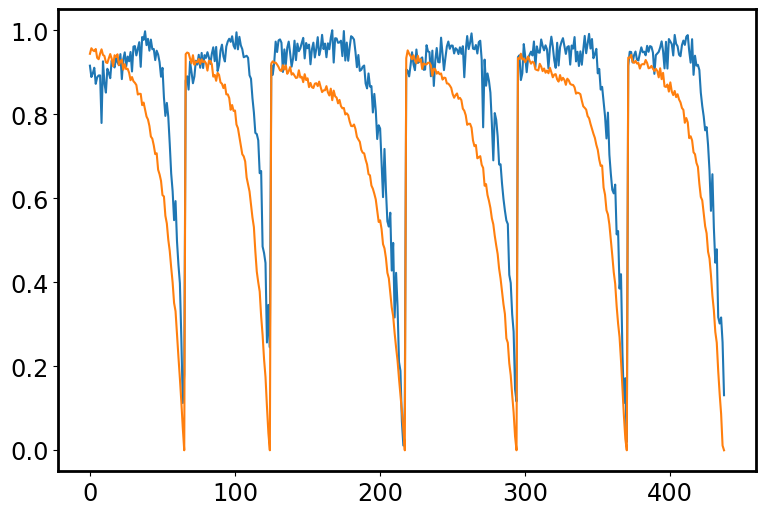

In [79]:
plt.plot(z_test[0], label = 'Predicted HI')
plt.plot(true_hi_test,label = 'True HI')

In [80]:
cycles_smooth, units_smooth = eval_utils.smooth_cycle_units(C_windows_test,U_windows_test)

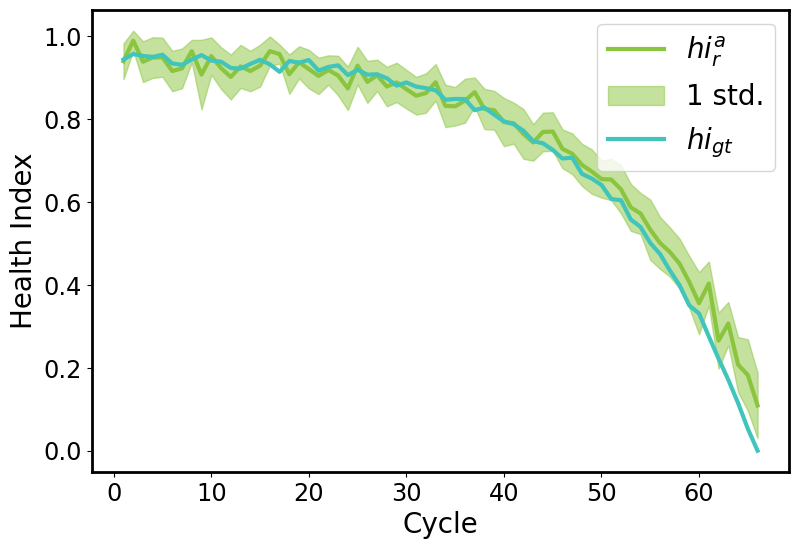

In [210]:
u = 10
run_id = 0
idx = np.ravel(units_smooth==u)
plt.plot(cycles_smooth[idx],z_test[run_id][idx],'#8BC53F',label = r'$hi_{r}^a$',linewidth = 3)
plt.fill_between(cycles_smooth[idx].ravel(),(z_test[run_id][idx]-z_test_std[run_id][idx]).ravel(),
                 (z_test[run_id][idx]+z_test_std[run_id][idx]).ravel(),alpha = 0.5,color = '#8BC53F',label = '1 std.')

idx2 = np.ravel(g_units==u)
plt.plot(g_cycles[idx2],g_his[idx2],'#3FC5BC',label = r'$hi_{gt}$' ,linewidth = 3)
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Health Index')
plt.show()

# Residual B

In [85]:
def H_index_residual_B(latent_dims, Window_size=100):
    # Define the dimensions of the input data
    x_dim = 14  # Dimensionality of the input data
    w_dim = 4   # Dimensionality of the additional input data

    # Define the input layer for the additional input data (W)
    inpW = tf.keras.layers.Input(shape=(Window_size, w_dim), name='inpW')

    # Initialize x with the input data (W)
    x = inpW

    # Apply convolutional layers with specified latent dimensions
    for i in latent_dims:
        # Apply a convolutional layer with i filters, relu activation, and same padding
        x = tf.keras.layers.Conv1D(i, 11, strides=1, activation='relu', padding='same')(x)

    # Apply a convolutional layer with x_dim filters, no activation, and same padding
    x = tf.keras.layers.Conv1D(x_dim, 11, strides=1, activation=None, padding='same')(x)

    # Define the model with input and output
    model = tf.keras.models.Model(inpW, x)

    return model


In [89]:
model_type = 'B'
layers=[64,64,64,64]
Window_size = X_windows.shape[1]
model = H_index_residual_B(layers,Window_size)

In [90]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_residual_model(model_type,X_windows, W_windows, C_windows, U_windows, Y_windows,true_hi_train,X_windows_test, W_windows_test, C_windows_test, U_windows_test, Y_windows_test,true_hi_test,
                                             model,healthy_thresholds = [20],runs = 1, epochs = 20, batch_size=512,learning_rate = 0.0001)

reset_weights
Epoch 1/20
295/295 [==============================] - 6s 14ms/step - loss: 0.0921
Epoch 2/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0108
Epoch 3/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0070
Epoch 4/20
295/295 [==============================] - 5s 14ms/step - loss: 0.0057
Epoch 5/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0050
Epoch 6/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0046
Epoch 7/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0043
Epoch 8/20
295/295 [==============================] - 5s 14ms/step - loss: 0.0041
Epoch 9/20
295/295 [==============================] - 4s 14ms/step - loss: 0.0039
Epoch 10/20
295/295 [==============================] - 5s 14ms/step - loss: 0.0037
Epoch 11/20
295/295 [==============================] - 5s 14ms/step - loss: 0.0036
Epoch 12/20
295/295 [==============================] - 5s 14ms/step - loss: 0.0035

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


789/789 [==============================] - 4s 5ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


{'MAE_TR': [0.051582488553737905], 'MAPE_TR': [16.315061297157065], 'M_TR': [0.32884444922514144], 'T_TR': [0.9532194701246206], 'FC_TR': [0.8795077], 'MI_TR': [0.6913644992737944], 'MAE_TS': [0.041926109606029806], 'MAPE_TS': [9.271626239494855], 'M_TS': [0.3454962532229162], 'T_TS': [0.9556372161394348], 'FC_TS': [0.9730128], 'MI_TS': [0.6561176686190558], 'TIME': [123.48669195175171], 'I': [20]}


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [91]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,0.051582,16.315061,0.328844,0.953219,0.879508,0.691364,0.041926,9.271626,0.345496,0.955637,0.973013,0.656118,123.486692,20


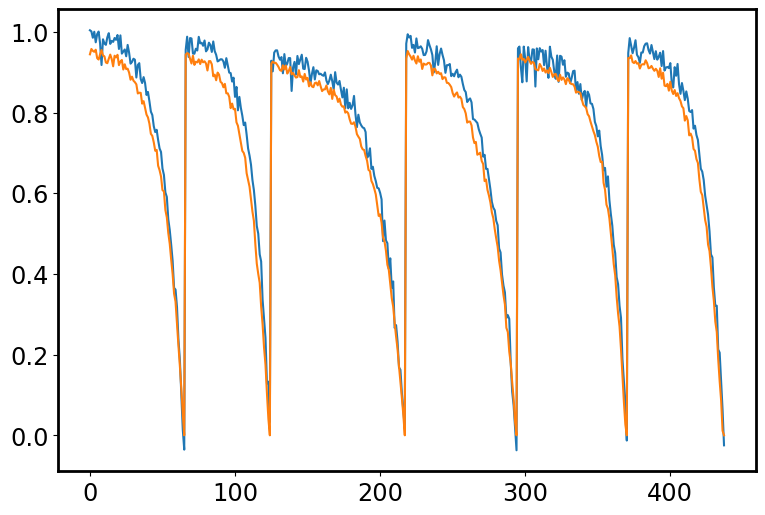

In [92]:
plt.plot(z_test[0], label = 'Predicted HI')
plt.plot(true_hi_test,label = 'True HI')

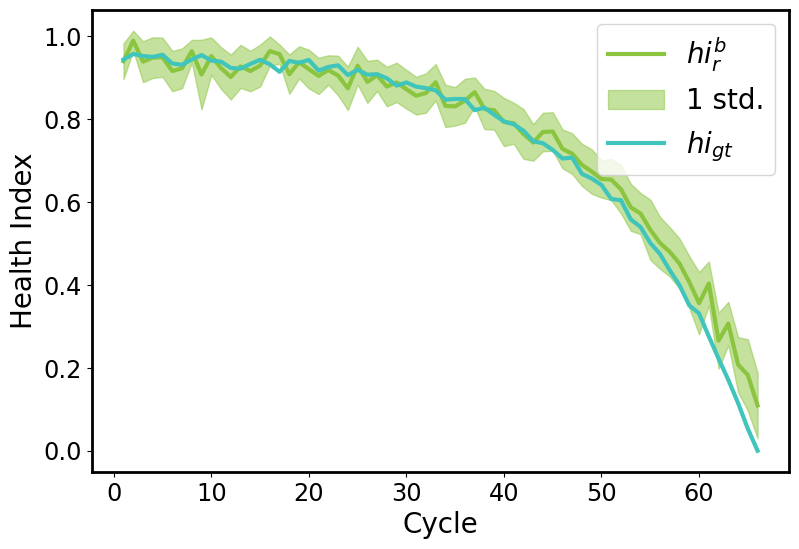

In [211]:
cycles_smooth, units_smooth = eval_utils.smooth_cycle_units(C_windows_test,U_windows_test)
u = 10
run_id = 0
idx = np.ravel(units_smooth==u)
plt.plot(cycles_smooth[idx],z_test[run_id][idx],'#8BC53F',label = r'$hi_{r}^b$',linewidth = 3)
plt.fill_between(cycles_smooth[idx].ravel(),(z_test[run_id][idx]-z_test_std[run_id][idx]).ravel(),
                 (z_test[run_id][idx]+z_test_std[run_id][idx]).ravel(),alpha = 0.5,color = '#8BC53F',label = '1 std.')

idx2 = np.ravel(g_units==u)
plt.plot(g_cycles[idx2],g_his[idx2],'#3FC5BC',label = r'$hi_{gt}$' ,linewidth = 3)
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Health Index')
plt.show()

# Supervised

In [5]:
# Define a supervised model for predicting health index (HI)
def H_index_residual_supervised(latent_dims, Window_size):
    # Define the dimensions of input data
    x_dim = 14  # Dimensionality of sensor data (X)
    w_dim = 4   # Dimensionality of additional input data (W)
    h_dim = 1   # Dimensionality of the predicted health index (HI)

    # Define input layers for sensor data (X) and additional input data (W)
    inpX = tf.keras.layers.Input(shape=(Window_size, x_dim), name='InpX')
    inpW = tf.keras.layers.Input(shape=(Window_size, w_dim), name='inpW')
    
    # Concatenate sensor data (X) and additional input data (W) along the feature axis
    x = tf.concat([inpX, inpW], axis=-1)

    # Apply convolutional layers with specified latent dimensions
    for i in latent_dims:
        # Apply a 1D convolutional layer with i filters, relu activation, and same padding
        x = tf.keras.layers.Conv1D(i, 11, 1, activation='relu', padding='same')(x)
        # Apply batch normalization to stabilize and accelerate the training process
        x = tf.keras.layers.BatchNormalization()(x)
        # Apply max pooling to downsample the feature maps
        x = tf.keras.layers.MaxPooling1D()(x)

    # Flatten the output of convolutional layers
    x = tf.keras.layers.Flatten()(x)
    # Apply a fully connected dense layer to predict the health index (HI)
    x = tf.keras.layers.Dense(h_dim, name='X')(x)
    
    # Define the model with inputs (sensor data and additional input data) and output (predicted health index)
    model = tf.keras.models.Model([inpX, inpW], x)
    
    return model


In [10]:
layers= [64,64,64,64]
Window_size = X_windows.shape[1]
model = H_index_residual_supervised(layers,Window_size)

In [7]:
hi_train = eval_utils.expand_hi(C_windows,U_windows,true_hi_train,true_hi_cycles.reshape(-1,1),true_hi_units.reshape(-1,1))     
hi_test = eval_utils.expand_hi(C_windows_test,U_windows_test,true_hi_test,true_hi_cycles_test,true_hi_units_test)

/baja/CMAPSS_GITHUB/eval_utils.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = np.array(result)


In [11]:
result,z_train,z_train_std,z_test,z_test_std = eval_utils.train_and_evaluate_supervised_model(X_windows, W_windows, C_windows, U_windows, Y_windows,hi_train,true_hi_train,X_windows_test, W_windows_test, C_windows_test, U_windows_test, Y_windows_test,hi_test,true_hi_test,
                                             model,runs = 1, epochs = 20, batch_size=512,learning_rate = 0.0001)

RUN#:  0
reset_weights
Epoch 1/20


2024-05-01 10:56:50.447434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-05-01 10:56:51.334305: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x4b345010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-01 10:56:51.334366: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla P40, Compute Capability 6.1
2024-05-01 10:56:51.334376: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): Tesla P40, Compute Capability 6.1
2024-05-01 10:56:51.334384: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): Tesla P40, Compute Capability 6.1
2024-05-01 10:56:51.334393: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (3): Tesla P40, Compute Capability 6.1
2024-05-01 10:56:51.334401: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (4): Tesla P40, Compute Cap

1025/1025 [==============================] - 32s 23ms/step - loss: 0.1090
Epoch 2/20
1025/1025 [==============================] - 26s 24ms/step - loss: 0.0555
Epoch 3/20
1025/1025 [==============================] - 26s 23ms/step - loss: 0.0468
Epoch 4/20
1025/1025 [==============================] - 26s 23ms/step - loss: 0.0426
Epoch 5/20
1025/1025 [==============================] - 25s 23ms/step - loss: 0.0401
Epoch 6/20
1025/1025 [==============================] - 27s 24ms/step - loss: 0.0361
Epoch 7/20
1025/1025 [==============================] - 30s 27ms/step - loss: 0.0359
Epoch 8/20
1025/1025 [==============================] - 29s 26ms/step - loss: 0.0342
Epoch 9/20
1025/1025 [==============================] - 28s 25ms/step - loss: 0.0317
Epoch 10/20
1025/1025 [==============================] - 28s 25ms/step - loss: 0.0302
Epoch 11/20
1025/1025 [==============================] - 29s 26ms/step - loss: 0.0308
Epoch 12/20
1025/1025 [==============================] - 26s 24ms/step - l

/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


789/789 [==============================] - 6s 7ms/step


/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


{'MAE_TR': [0.023848589381515916], 'MAPE_TR': [7.169453159159618], 'M_TR': [0.42095984145643267], 'T_TR': [0.9873786517637657], 'FC_TR': [0.93769705], 'MI_TR': [0.7362506175457992], 'MAE_TS': [0.029355458220624794], 'MAPE_TS': [8.667524096063104], 'M_TS': [0.4268061196980948], 'T_TS': [0.9878646210178373], 'FC_TS': [0.9282738], 'MI_TS': [0.6922839979851241], 'TIME': [569.4816110134125], 'I': [0]}


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [12]:
pd.DataFrame(result)

,MAE_TR,MAPE_TR,M_TR,T_TR,FC_TR,MI_TR,MAE_TS,MAPE_TS,M_TS,T_TS,FC_TS,MI_TS,TIME,I
0,0.023849,7.169453,0.42096,0.987379,0.937697,0.736251,0.029355,8.667524,0.426806,0.987865,0.928274,0.692284,569.481611,0


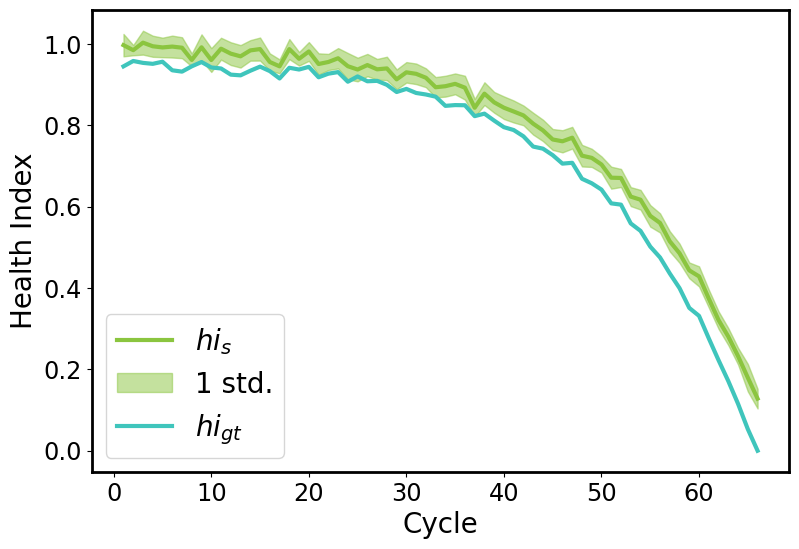

In [13]:
cycles_smooth, units_smooth = eval_utils.smooth_cycle_units(C_windows_test,U_windows_test)
u = 10
run_id = 0
idx = np.ravel(units_smooth==u)
plt.plot(cycles_smooth[idx],z_test[run_id][idx],'#8BC53F',label = r'$hi_{s}$',linewidth = 3)
plt.fill_between(cycles_smooth[idx].ravel(),(z_test[run_id][idx]-z_test_std[run_id][idx]).ravel(),
                 (z_test[run_id][idx]+z_test_std[run_id][idx]).ravel(),alpha = 0.5,color = '#8BC53F',label = '1 std.')

idx2 = np.ravel(g_units==u)
plt.plot(g_cycles[idx2],g_his[idx2],'#3FC5BC',label = r'$hi_{gt}$' ,linewidth = 3)
plt.legend()
plt.xlabel('Cycle')
plt.ylabel('Health Index')
plt.show()

In [14]:
run_id = 0
np.save(PATH_IN + '/z_supervised_train.npy',z_train[run_id])
np.save(PATH_IN + '/z_supervised_test.npy',z_test[run_id])